In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import cv2
import os

# --------------------
# CONFIG
# --------------------
model_path = "/home/debasish/Documents/YOLOv8/weights/pose-weights/yolov8x-832.pt"
video_input = Path("/home/debasish/Documents/YOLOv8/videos/videos/image007.mp4")  # single file or folder
timestep = 30.0  # for velocity calculation
output_base_dir = Path("outputs/orientation")
output_base_dir.mkdir(parents=True, exist_ok=True)

video_extensions = [".mp4", ".avi", ".mov", ".mkv"]

# --------------------
# Collect video list
# --------------------
if video_input.is_file() and video_input.suffix.lower() in video_extensions:
    video_files = [video_input]
elif video_input.is_dir():
    video_files = []
    for ext in video_extensions:
        video_files.extend(video_input.glob(f"*{ext}"))
    video_files = sorted(video_files)
else:
    raise ValueError(f"Input must be a video file ({video_extensions}) or a folder containing such files")

if not video_files:
    raise FileNotFoundError(f"No supported video files found in {video_input}")

# --------------------
# Load YOLO model once
# --------------------
model = YOLO(model_path)

# --------------------
# Process each video
# --------------------
for video_path in video_files:
    print(f"\nProcessing video: {video_path.name}")

    # Create new run folder
    existing_runs = [d for d in output_base_dir.iterdir() if d.is_dir() and d.name.startswith("run")]
    run_num = len(existing_runs) + 1
    run_dir = output_base_dir / f"run{run_num}"
    run_dir.mkdir(parents=True, exist_ok=True)

    out_video_path = run_dir / f"{video_path.stem}_tracked.avi"
    out_csv_path = run_dir / f"{video_path.stem}_positions.csv"
    speed_csv_path = run_dir / f"{video_path.stem}_speed.csv"

    # --------------------
    # Tracking (video-level)
    # --------------------
    results = model.track(
        source=str(video_path), tracker="bytetrack.yaml", persist=True, stream=True, verbose=True)

    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    writer = cv2.VideoWriter(str(out_video_path), fourcc, fps, (width, height))
    if not writer.isOpened():
        raise RuntimeError(f"Failed to open VideoWriter: {out_video_path}")

    # Tracking variables
    frame_num = 0
    frames, obj_ids, obj_clss, x, y, w, h = [], [], [], [], [], [], []
    trajectories, worm_colors = {}, {}

    for result in results:
        frame_num += 1
        ret, frame_img = cap.read()
        if not ret:
            break

        boxes = result.boxes
        if boxes is None or len(boxes) == 0 or boxes.cls is None or boxes.id is None or boxes.xywh is None:
            writer.write(frame_img)
            continue

        obj_cls = boxes.cls.cpu().numpy()
        obj_id = boxes.id.cpu().numpy().astype(int)
        xywh = boxes.xywh.cpu().numpy()

        for i, j, k in zip(obj_cls, obj_id, xywh):
            frames.append(frame_num)
            obj_clss.append(int(i))
            obj_ids.append(int(j))
            x.append(k[0]); y.append(k[1]); w.append(k[2]); h.append(k[3])

            # Update trajectory and color
            if j not in trajectories:
                trajectories[j] = []
                worm_colors[j] = tuple(np.random.randint(0, 255, size=3).tolist())
            trajectories[j].append((int(k[0]), int(k[1])))

        # Draw trajectories and IDs
        for worm_id, points in trajectories.items():
            color = worm_colors[worm_id]
            for pt_idx in range(1, len(points)):
                cv2.line(frame_img, points[pt_idx-1], points[pt_idx], color=color, thickness=2)
            if len(points) > 0:
                last_point = points[-1]
                cv2.putText(frame_img, str(worm_id), (last_point[0]+5, last_point[1]-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        writer.write(frame_img)

    cap.release()
    writer.release()
    print(f"Tracked video saved at: {out_video_path}")

    # --------------------
    # Save coordinates CSV
    # --------------------
    data = {"frame": frames, "obj_cls": obj_clss, "obj_id": obj_ids}
    bbox_out = {"x": x, "y": y, "w": w, "h": h}
    coords_df = pd.concat([pd.DataFrame(data), pd.DataFrame(bbox_out)], axis=1)
    coords_df.to_csv(out_csv_path, index=False)
    print(f"Coordinates CSV saved: {out_csv_path}")

    # --------------------
    # Compute distance & velocity
    # --------------------
    worm_ids = sorted(coords_df["obj_id"].unique())
    distances, velocities = [], []

    for worm_id in worm_ids:
        df_w = coords_df[coords_df["obj_id"] == worm_id]
        x_vals = df_w["x"].values
        y_vals = df_w["y"].values

        if len(x_vals) < 2:
            distances.append(0)
            velocities.append(0)
            continue

        dx = np.diff(x_vals)
        dy = np.diff(y_vals)
        distance = np.sum(np.sqrt(dx**2 + dy**2))
        velocity = distance / timestep

        distances.append(distance)
        velocities.append(velocity)

    # Save speed summary CSV
    track_outputs = pd.DataFrame({
        "worm_id": worm_ids,
        "Distance (pixels)": distances,
        "Velocity (pixels/s)": velocities
    })
    track_outputs.to_csv(speed_csv_path, index=False)
    print(f"Speed summary saved: {speed_csv_path}")


Processing video: image007.mp4

video 1/1 (frame 1/3038) /home/debasish/Documents/YOLOv8/videos/videos/image007.mp4: 480x832 1 worm, 20.9ms
video 1/1 (frame 2/3038) /home/debasish/Documents/YOLOv8/videos/videos/image007.mp4: 480x832 1 worm, 20.3ms
video 1/1 (frame 3/3038) /home/debasish/Documents/YOLOv8/videos/videos/image007.mp4: 480x832 1 worm, 20.9ms
video 1/1 (frame 4/3038) /home/debasish/Documents/YOLOv8/videos/videos/image007.mp4: 480x832 1 worm, 21.6ms
video 1/1 (frame 5/3038) /home/debasish/Documents/YOLOv8/videos/videos/image007.mp4: 480x832 1 worm, 21.8ms
video 1/1 (frame 6/3038) /home/debasish/Documents/YOLOv8/videos/videos/image007.mp4: 480x832 1 worm, 21.0ms
video 1/1 (frame 7/3038) /home/debasish/Documents/YOLOv8/videos/videos/image007.mp4: 480x832 1 worm, 21.9ms
video 1/1 (frame 8/3038) /home/debasish/Documents/YOLOv8/videos/videos/image007.mp4: 480x832 1 worm, 22.3ms
video 1/1 (frame 9/3038) /home/debasish/Documents/YOLOv8/videos/videos/image007.mp4: 480x832 1 worm, 19

✅ Results saved to: /home/debasish/Documents/YOLOv8/outputs/orientation_analysis/run1/orientation_analysis.csv


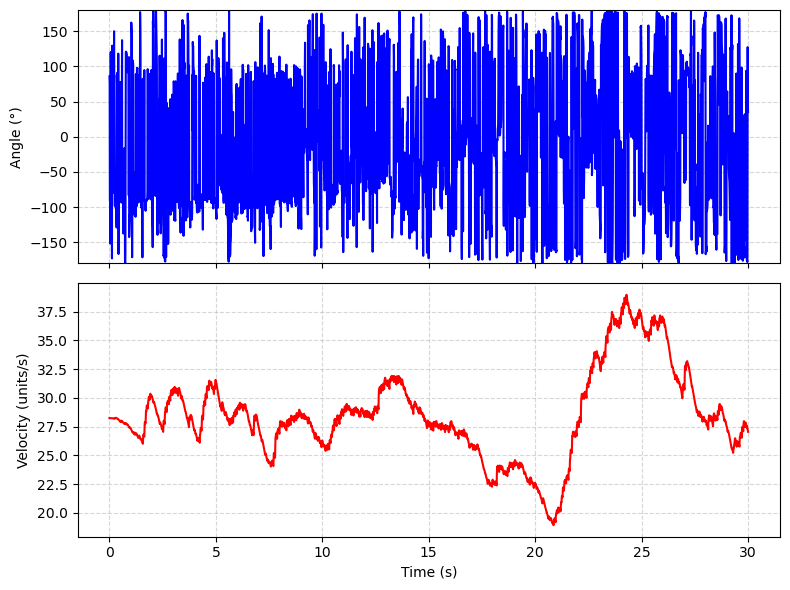

In [31]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter


def import_data(file):
    """Import trajectory data for a single worm."""
    df = pd.read_csv(file)
    frame = df['frame'].to_numpy()
    x = df['x'].to_numpy()
    y = df['y'].to_numpy()
    return frame, x, y


def kalman_filter(data):
    """Apply Kalman filter to smooth noisy 1D trajectory data."""
    kf = KalmanFilter(initial_state_mean=data[0],
                      n_dim_obs=1,
                      transition_covariance=1e-4,
                      observation_covariance=1e-1)
    kf = kf.em(data, n_iter=10)  # estimate parameters
    filtered_state_means, _ = kf.filter(data)
    return filtered_state_means.ravel()


def calc_velocity(x, y, dt):
    """Calculate instantaneous velocity magnitude."""
    dx = np.diff(x)
    dy = np.diff(y)
    dr = np.sqrt(dx**2 + dy**2)
    vel = dr / dt
    return vel


def calc_angle(x, y):
    """Calculate movement orientation angle (in degrees)."""
    vx = np.diff(x)
    vy = np.diff(y)
    angles = np.degrees(np.arctan2(vy, vx))  # range (-180, 180)
    return angles


def save_results(out_dir, frame, smooth_x, smooth_y, smooth_v, angle):
    """Save smoothed positions, velocity, and orientation to CSV."""
    os.makedirs(out_dir, exist_ok=True)
    df_out = pd.DataFrame({
        "frame": frame[:-1],
        "smooth_x": smooth_x[:-1],
        "smooth_y": smooth_y[:-1],
        "velocity": smooth_v,
        "angle_deg": angle
    })
    out_path = os.path.join(out_dir, "orientation_analysis.csv")
    df_out.to_csv(out_path, index=False)
    print(f"Results saved to: {out_path}")


def plot_results(smooth_v, angle, t_tot, N):
    """Plot orientation and velocity vs. time."""
    T = np.linspace(0, t_tot, N - 1)
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    ax[0].plot(T, angle, color='blue')
    ax[0].set_ylabel("Angle (°)")
    ax[0].set_ylim(-180, 180)
    ax[0].grid(True, linestyle='--', alpha=0.5)

    ax[1].plot(T, smooth_v, color='red')
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Velocity (units/s)")
    ax[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    # ---- User parameters ----
    data = "/home/debasish/Documents/YOLOv8/outputs/orientation/run1/image003_positions.csv"
    t_tot = 30  # total time (seconds)
    output_dir = "/home/debasish/Documents/YOLOv8/outputs/orientation_analysis/run1"

    # ---- Load data ----
    frame, x, y = import_data(data)
    N = len(frame)
    dt = t_tot / N

    # ---- Kalman filtering ----
    smooth_x = kalman_filter(x)
    smooth_y = kalman_filter(y)

    # ---- Velocity and angle ----
    vel = calc_velocity(smooth_x, smooth_y, dt)
    smooth_v = kalman_filter(vel)
    angle = calc_angle(smooth_x, smooth_y)

    # ---- Save and plot ----
    save_results(output_dir, frame, smooth_x, smooth_y, smooth_v, angle)
    plot_results(smooth_v, angle, t_tot, N)

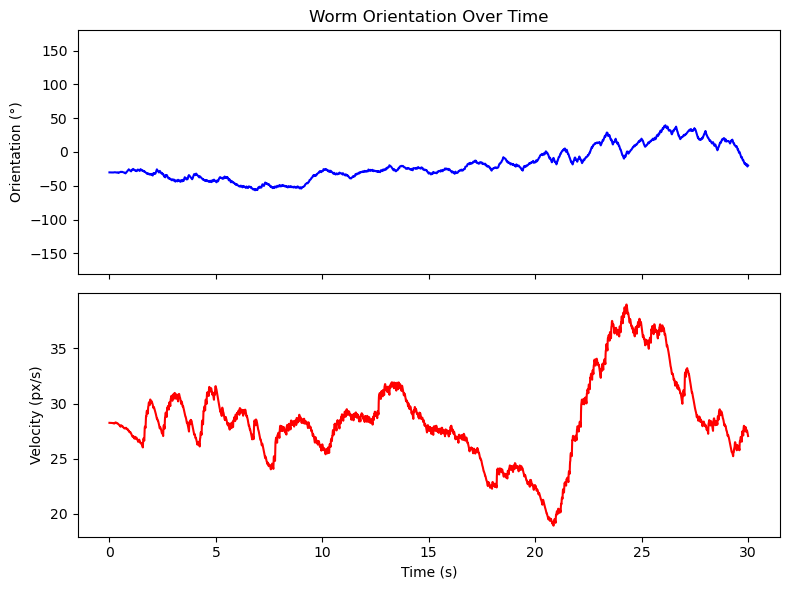

Saved analysis to: /home/debasish/Documents/YOLOv8/outputs/orientation/run1/analysis/image003_positions_analysis.csv


In [43]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import os


def import_data(file):
    """Import trajectory data which is used for further analysis"""
    df = pd.read_csv(file)

    frame = df['frame'].to_numpy()
    worm_id = df['obj_id'].to_numpy()
    x = df['x'].to_numpy()
    y = df['y'].to_numpy()
    
    return frame, worm_id, x, y


def calc_velocity(x, y, dt):
    """Calculating velocity magnitude between consecutive positions"""
    dx = np.diff(x)
    dy = np.diff(y)
    dr = np.sqrt(dx**2 + dy**2)
    vel = dr / dt
    return vel


def kalman_smooth(data):
    """Apply Kalman filter for smoothing 1D trajectory data"""
    data = np.array(data)
    kf = KalmanFilter(initial_state_mean=data[0],
                      n_dim_obs=1,
                      transition_covariance=1e-4,
                      observation_covariance=0.1)
    
    kf = kf.em(data, n_iter=10)
    smoothed_state_means, _ = kf.filter(data)
    return smoothed_state_means.flatten()


def calc_angle(smooth_x, smooth_y, dt):
    """Calculate orientation angle of motion in degrees"""
    vx = np.diff(smooth_x) / dt
    vy = np.diff(smooth_y) / dt
    theta = np.degrees(np.arctan2(vy, vx))  # gives range (-180, 180)
    
    # Smooth the angle slightly to reduce noise
    theta_smooth = kalman_smooth(theta)
    return theta_smooth


def analyze_trajectory(data_path, t_tot=30, save_output=True):
    """Full analysis pipeline for a single trajectory"""
    frame, worm_id, x, y = import_data(data_path)
    N = len(frame)
    dt = t_tot / N

    # Apply smoothing filters
    smooth_x = kalman_smooth(x)
    smooth_y = kalman_smooth(y)
    vel = calc_velocity(smooth_x, smooth_y, dt)
    smooth_v = kalman_smooth(vel)
    angle = calc_angle(smooth_x, smooth_y, dt)

    # Time axis for plotting
    T = np.linspace(0, t_tot, len(angle))

    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    ax[0].plot(T, angle, color='blue')
    ax[0].set_ylabel("Orientation (°)")
    ax[0].set_ylim(-180, 180)
    ax[0].set_title("Worm Orientation Over Time")

    ax[1].plot(T, smooth_v, color='red')
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Velocity (px/s)")
    plt.tight_layout()
    plt.show()

    # Save results
    if save_output:
        output_dir = os.path.join(os.path.dirname(data_path), "analysis")
        os.makedirs(output_dir, exist_ok=True)
        base_name = os.path.splitext(os.path.basename(data_path))[0]
        save_csv = os.path.join(output_dir, f"{base_name}_analysis.csv")
        df_out = pd.DataFrame({
            "time": T,
            "angle_deg": angle,
            "velocity": smooth_v[:len(angle)]
        })
        df_out.to_csv(save_csv, index=False)
        print(f"Saved analysis to: {save_csv}")

    return angle, smooth_v, smooth_x, smooth_y


if __name__ == "__main__":
    data_file = "/home/debasish/Documents/YOLOv8/outputs/orientation/run1/image003_positions.csv"
    angle, smooth_v, smooth_x, smooth_y = analyze_trajectory(data_file, t_tot=30, save_output=True)

(719.0, 0.0)

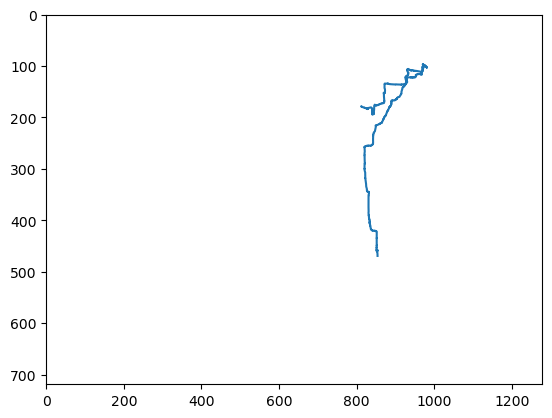

In [37]:
plt.plot(x,y)
plt.xlim(0,1279)
plt.ylim(719,0)

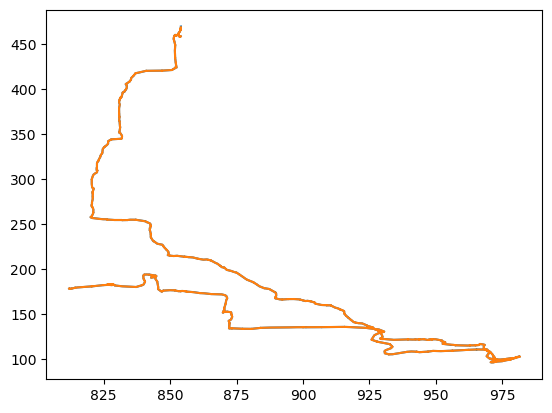

In [44]:
# smooth_x = kalman_smooth(x)
# smooth_y = kalman_smooth(y)

plt.plot(x, y)
plt.plot(smooth_x, smooth_y)